In [1]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('BDAS').getOrCreate()

In [2]:
import pandas as pd

In [3]:
df35 = spark.read.csv('1-3.csv',inferSchema=True,header=True)

In [4]:
print((df35.count(), len(df35.columns)))

(8866, 132)


In [5]:
columns = df35.columns
names = []
for c1 in columns:
        corr = df35.corr(c1, 'Target2')
        if abs(corr) >= 0.2:
            names.append(c1)
names

['rooms',
 'v18q',
 'r4h1',
 'r4m1',
 'r4t1',
 'escolari',
 'paredblolad',
 'pisomoscer',
 'cielorazo',
 'epared1',
 'epared3',
 'etecho3',
 'eviv1',
 'eviv3',
 'hogar_nin',
 'edjefe',
 'edjefa',
 'meaneduc',
 'instlevel8',
 'overcrowding',
 'qmobilephone',
 'dependency_rate',
 'Target2']

In [6]:
df42 = df35.select('rooms',
 'v18q',
 'r4h1',
 'r4m1',
 'r4t1',
 'escolari',
 'paredblolad',
 'pisomoscer',
 'cielorazo',
 'epared1',
 'epared3',
 'etecho3',
 'eviv1',
 'eviv3',
 'hogar_nin',
 'edjefe',
 'edjefa',
 'meaneduc',
 'instlevel8',
 'overcrowding',
 'qmobilephone',
 'dependency_rate',
 'Target2')

In [7]:
import seaborn as sns

sns.countplot("Target2", data=df42.toPandas())

In [8]:
df_a = df42.filter(df42['Target2'] == 4)
df_b = df42.filter(df42['Target2'] == 1)
df_c = df42.filter(df42['Target2'] == 2)
df_d = df42.filter(df42['Target2'] == 3)

a_count = df_a.count()
b_count = df_b.count()
c_count = df_c.count() 
d_count = df_d.count() 

ratio = a_count / b_count
ratio2 = a_count / c_count
ratio3 = a_count / d_count

df_b_overampled = df_b.sample(withReplacement=True, fraction=ratio, seed=1)
df_c_overampled = df_c.sample(withReplacement=True, fraction=ratio2, seed=1)
df_d_overampled = df_d.sample(withReplacement=True, fraction=ratio3, seed=1)


df = df_a.unionAll(df_b_overampled)
df2 = df.unionAll(df_c_overampled)
df42 = df2.unionAll(df_d_overampled)

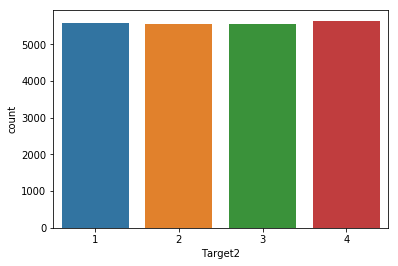

In [9]:
import seaborn as sns

sns.countplot("Target2", data=df42.toPandas())

In [10]:
print((df42.count(), len(df42.columns)))

(22303, 23)


In [11]:
print(df42.columns)
print(df42.head())

['rooms', 'v18q', 'r4h1', 'r4m1', 'r4t1', 'escolari', 'paredblolad', 'pisomoscer', 'cielorazo', 'epared1', 'epared3', 'etecho3', 'eviv1', 'eviv3', 'hogar_nin', 'edjefe', 'edjefa', 'meaneduc', 'instlevel8', 'overcrowding', 'qmobilephone', 'dependency_rate', 'Target2']
Row(rooms=6, v18q=0, r4h1=0, r4m1=0, r4t1=0, escolari=6, paredblolad=0, pisomoscer=1, cielorazo=1, epared1=1, epared3=0, etecho3=0, eviv1=0, eviv3=1, hogar_nin=0, edjefe=6, edjefa=6, meaneduc=6.75, instlevel8=0, overcrowding=1.0, qmobilephone=4, dependency_rate=0.0, Target2=4)


In [12]:
import gc
del df
del df2
gc.collect()

89

In [13]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
   inputCols=df42.columns[0:22], outputCol="features")
output61 = assembler.transform(df42)

In [14]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="Target2", outputCol="targetIndex")
output_fixed = indexer.fit(output61).transform(output61)
final_data = output_fixed.select("features",'targetIndex')

In [15]:
print(output_fixed.printSchema())
print(final_data.head())

root
 |-- rooms: integer (nullable = true)
 |-- v18q: integer (nullable = true)
 |-- r4h1: integer (nullable = true)
 |-- r4m1: integer (nullable = true)
 |-- r4t1: integer (nullable = true)
 |-- escolari: integer (nullable = true)
 |-- paredblolad: integer (nullable = true)
 |-- pisomoscer: integer (nullable = true)
 |-- cielorazo: integer (nullable = true)
 |-- epared1: integer (nullable = true)
 |-- epared3: integer (nullable = true)
 |-- etecho3: integer (nullable = true)
 |-- eviv1: integer (nullable = true)
 |-- eviv3: integer (nullable = true)
 |-- hogar_nin: integer (nullable = true)
 |-- edjefe: integer (nullable = true)
 |-- edjefa: integer (nullable = true)
 |-- meaneduc: double (nullable = true)
 |-- instlevel8: integer (nullable = true)
 |-- overcrowding: double (nullable = true)
 |-- qmobilephone: integer (nullable = true)
 |-- dependency_rate: double (nullable = true)
 |-- Target2: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- targetIndex: double

In [16]:
dtc = DecisionTreeClassifier(labelCol='targetIndex',featuresCol='features')
dtc_model = dtc.fit(final_data)

In [17]:
print(dtc_model.toDebugString)

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_446eb210bf514b4effe1) of depth 5 with 61 nodes
  If (feature 17 <= 11.0)
   If (feature 4 <= 1.0)
    If (feature 17 <= 6.3333335)
     If (feature 10 <= 0.0)
      If (feature 15 <= 4.0)
       Predict: 1.0
      Else (feature 15 > 4.0)
       Predict: 2.0
     Else (feature 10 > 0.0)
      If (feature 19 <= 1.3333334)
       Predict: 3.0
      Else (feature 19 > 1.3333334)
       Predict: 2.0
    Else (feature 17 > 6.3333335)
     If (feature 14 <= 0.0)
      If (feature 20 <= 2.0)
       Predict: 0.0
      Else (feature 20 > 2.0)
       Predict: 0.0
     Else (feature 14 > 0.0)
      If (feature 17 <= 9.0)
       Predict: 3.0
      Else (feature 17 > 9.0)
       Predict: 0.0
   Else (feature 4 > 1.0)
    If (feature 15 <= 3.0)
     If (feature 20 <= 3.0)
      If (feature 8 <= 0.0)
       Predict: 1.0
      Else (feature 8 > 0.0)
       Predict: 1.0
     Else (feature 20 > 3.0)
      If (feature 1 <= 0.0)
       Predict: 1.

In [18]:
import json


def parse(lines):
	block = []
	while lines :
		if lines[0].startswith('If'):
			bl = ' '.join(lines.pop(0).split()[1:]).replace('(', '').replace(')', '')
			block.append({'name':bl, 'children':parse(lines)})
				
				
			if lines[0].startswith('Else'):
				be = ' '.join(lines.pop(0).split()[1:]).replace('(', '').replace(')', '')
				block.append({'name':be, 'children':parse(lines)})
		elif not lines[0].startswith(('If','Else')):
			block2 = lines.pop(0)
			block.append({'name':block2})
		else:
			break	
	return block
	
	# Convert Tree to JSON
def tree_json(tree):
	data = []
	for line in tree.splitlines() : 
		if line.strip():
			line = line.strip()
			data.append(line)
		else : break
		if not line : break
	res = []
	res.append({'name':'Root', 'children':parse(data[1:])})
	with open('Decision-Tree-Visualization-Spark/data/structure.json', 'w') as outfile:
		json.dump(res[0], outfile)
	print ('Conversion Success !')

def tree_feature_json(tree, columns):
    tree_str = tree
    for i in range(len(columns)-1, -1, -1):
        tree_str = tree_str.replace("feature "+str(i), columns[i])
    tree_json(tree_str)

In [19]:
tree_feature_json(dtc_model.toDebugString, df42.columns)

Conversion Success !


In [20]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
my_binary_eval = BinaryClassificationEvaluator(labelCol = 'targetIndex')

In [21]:
dtc3 = DecisionTreeClassifier(labelCol='targetIndex',featuresCol='features', maxDepth=10)
dtc_model3 = dtc3.fit(final_data)

tree_feature_json(dtc_model3.toDebugString, df42.columns)

dtc_predictions3 = dtc_model3.transform(final_data)
print(my_binary_eval.evaluate(dtc_predictions3))

Conversion Success !
0.660901680728005


In [22]:
dtc4 = DecisionTreeClassifier(labelCol='targetIndex',featuresCol='features', maxDepth=4)
dtc_model4 = dtc4.fit(final_data)

tree_feature_json(dtc_model4.toDebugString, df42.columns)

dtc_predictions4 = dtc_model4.transform(final_data)
print(my_binary_eval.evaluate(dtc_predictions4))

Conversion Success !
0.7375963213326748


In [23]:
dtc5 = DecisionTreeClassifier(labelCol='targetIndex',featuresCol='features', maxDepth=5)
dtc_model5 = dtc5.fit(final_data)

tree_feature_json(dtc_model5.toDebugString, df42.columns)

dtc_predictions5 = dtc_model5.transform(final_data)
print(my_binary_eval.evaluate(dtc_predictions5))

Conversion Success !
0.7463262448816284


In [24]:
dtc63 = DecisionTreeClassifier(labelCol='targetIndex',featuresCol='features', maxDepth=4, minInstancesPerNode=2000)
dtc_model63 = dtc63.fit(final_data)

tree_feature_json(dtc_model63.toDebugString, df42.columns)

dtc_predictions63 = dtc_model63.transform(final_data)
print(my_binary_eval.evaluate(dtc_predictions63))

Conversion Success !
0.7172957515145547


In [25]:
#7.1	Create and justify test designs
train_data71,test_data71 = final_data.randomSplit([0.8,0.2])
print((train_data71.count(), len(train_data71.columns)))
print((test_data71.count(), len(test_data71.columns)))

(17919, 2)
(4384, 2)


In [26]:
#7.2	Conduct data mining
import time

start = time.time()

dtc_tree_72 = DecisionTreeClassifier(labelCol='targetIndex',featuresCol='features', maxDepth=4, minInstancesPerNode=2000)
dtc_tree_model_72 = dtc_tree_72.fit(train_data71)


tree_feature_json(dtc_tree_model_72.toDebugString, df42.columns)

dtc_tree_predictions_72 = dtc_tree_model_72.transform(test_data71)


end = time.time()
duration = end-start

print("Training duration: ", duration, " seconds")
print("Accuracy: ", my_binary_eval.evaluate(dtc_tree_predictions_72))



Conversion Success !
Training duration:  3.876182794570923  seconds
Accuracy:  0.6785903855570984


In [27]:
from pyspark.ml.classification import RandomForestClassifier

start = time.time()

forest_72 = RandomForestClassifier(labelCol='targetIndex',featuresCol='features')
forest_model_72 = forest_72.fit(train_data71)



forest_predictions_72 = forest_model_72.transform(test_data71)


end = time.time()
duration = end-start

print("Training duration: ", duration, " seconds")
print("Accuracy: ", my_binary_eval.evaluate(forest_predictions_72))

Training duration:  4.524969816207886  seconds
Accuracy:  0.8164498132350329


In [28]:
forest_model_72.featureImportances

SparseVector(22, {0: 0.0289, 1: 0.0462, 2: 0.0135, 3: 0.0406, 4: 0.055, 5: 0.0184, 6: 0.0173, 7: 0.0104, 8: 0.0322, 9: 0.0039, 10: 0.0626, 11: 0.0301, 12: 0.0055, 13: 0.0309, 14: 0.0515, 15: 0.067, 16: 0.0646, 17: 0.156, 18: 0.0343, 19: 0.0521, 20: 0.0426, 21: 0.1364})

In [29]:
features = df42.columns[0:22]
model = pd.DataFrame(forest_model_72.featureImportances.toArray(), columns=["values"])
features_col = pd.Series(features)
model["features"] = features_col
model.sort_values(by='values', ascending=False)

,values,features
17,0.155980,meaneduc
21,0.136380,dependency_rate
15,0.066984,edjefe
16,0.064632,edjefa
10,0.062553,epared3
4,0.055048,r4t1
19,0.052133,overcrowding
14,0.051451,hogar_nin
1,0.046173,v18q
20,0.042611,qmobilephone


In [30]:
from pyspark.ml.regression import LinearRegression

lr_72 = LinearRegression(labelCol='targetIndex',featuresCol='features')
lrModel = lr_72.fit(train_data71)
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)




Coefficients: [-0.035729026824456674,-0.2898500454271644,-0.08390655348429503,-0.07620772849940154,-0.07374266124002417,-0.0018691881105339103,-0.09480552449607614,0.015129403088782141,-0.028200336742600102,-0.0618715652706585,0.0705358442529492,-0.029987151758122152,-0.07339834398748141,-0.14638826363364713,0.168282492680911,0.00575060443955327,0.00575060443955327,-0.06349193418979358,-0.23035661305138244,-0.04403963125604245,0.015798538351670985,0.4880774851322797]
Intercept: 2.0207859516692457
numIterations: 22
objectiveHistory: [0.5, 0.46187780920442933, 0.45455661173193973, 0.4427846943132496, 0.4414191732996685, 0.4403685050538154, 0.440147971516783, 0.4400245389316554, 0.4399348134892772, 0.4399128853217915, 0.4399086951523391, 0.43990772595404537, 0.4399074764091755, 0.4399073959489975, 0.43990738469741886, 0.43990738273298213, 0.43990738257234774, 0.43990738254103845, 0.43990738252944306, 0.4399073825290709, 0.43990738252877937, 0.4399073825285682]
+--------------------+
|    

In [31]:
import statsmodels.api as sm
data71 = df42.toPandas()
Y72 = data71['Target2']
X72 = data71.drop('Target2', axis=1)

start = time.time()
mod = sm.OLS(Y72, X72)    # Describe model
res = mod.fit()       # Fit model
end = time.time()
duration = end-start
print("Training duration: ", duration, " seconds")
print(res.summary())

Training duration:  0.0804898738861084  seconds
                                 OLS Regression Results                                
Dep. Variable:                Target2   R-squared (uncentered):                   0.876
Model:                            OLS   Adj. R-squared (uncentered):              0.876
Method:                 Least Squares   F-statistic:                              7862.
Date:                Wed, 21 Oct 2020   Prob (F-statistic):                        0.00
Time:                        21:12:57   Log-Likelihood:                         -30890.
No. Observations:               22303   AIC:                                  6.182e+04
Df Residuals:                   22283   BIC:                                  6.198e+04
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025 

In [32]:
#7.3	Search for patterns
res.pvalues.sort_values()

rooms              1.241698e-286
hogar_nin          1.118799e-224
overcrowding       1.817355e-218
meaneduc           5.860866e-173
qmobilephone       8.714019e-132
edjefe              3.099329e-71
edjefa              3.099329e-71
dependency_rate     2.315713e-41
v18q                1.343601e-20
etecho3             3.359869e-17
pisomoscer          4.199447e-16
paredblolad         1.228178e-14
epared3             1.913778e-14
escolari            5.951385e-12
eviv1               2.327195e-11
r4m1                8.588050e-11
r4t1                3.524765e-09
eviv3               1.387069e-06
instlevel8          9.262860e-04
cielorazo           1.830655e-02
r4h1                2.899945e-01
epared1             7.814330e-01
dtype: float64

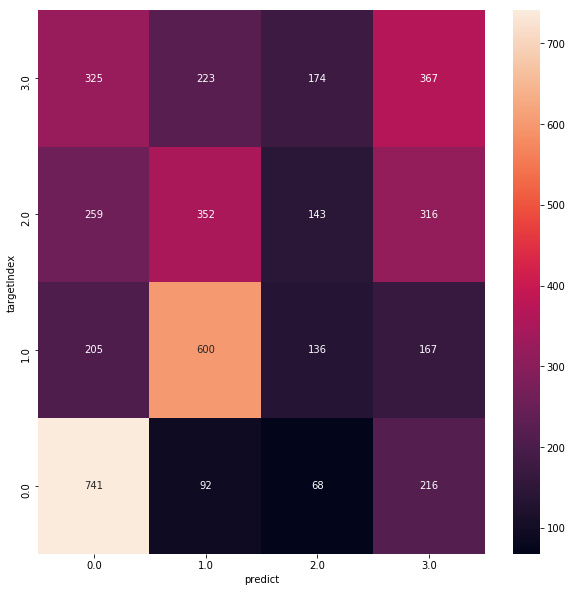

In [33]:
#8.2	Visualize the data, results, models, and patterns

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

prediction82 = dtc_tree_predictions_72.toPandas()

c82 = pd.crosstab(prediction82["targetIndex"], prediction82["prediction"])
c82.columns.name = 'predict'

plt.figure(figsize=(10,10))
#sns.set(font_scale=1.5)
sns.heatmap(c82, annot=True, fmt='d').invert_yaxis()
plt.show()

/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


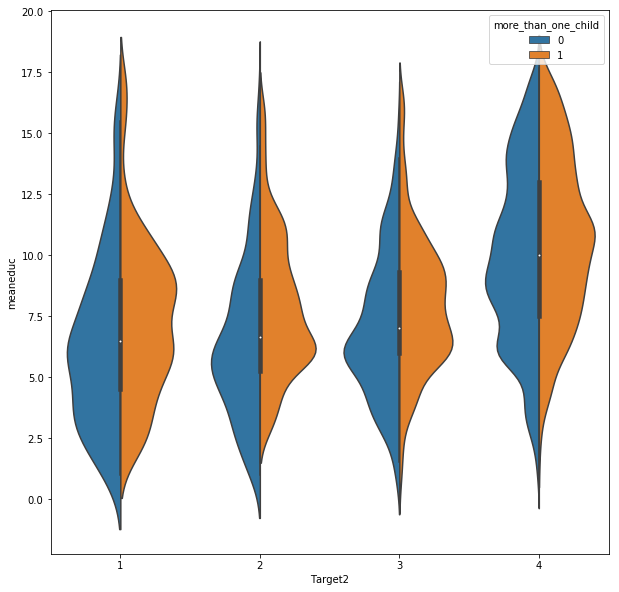

In [37]:
data82=data41

data82['hogar_nin'].value_counts()
data82['more_than_one_child']=0
data82['more_than_one_child'][data41['hogar_nin']>1]=1

plt.figure(figsize=(10,10))
sns.violinplot(x='Target2', y='meaneduc', hue='more_than_one_child', data=data41, split=True)

In [32]:
#8.4	Assess and evaluate results, models, and patterns

from statsmodels.tools import eval_measures

y_predict_regression = res.predict(X72)

eval_measures.meanabs(Y72, y_predict_regression)

0.7907525685563527

In [33]:
print(eval_measures.meanabs(dtc_tree_predictions_72.toPandas()["targetIndex"], dtc_tree_predictions_72.toPandas()["prediction"]))
print(eval_measures.meanabs(forest_predictions_72.toPandas()["targetIndex"], forest_predictions_72.toPandas()["prediction"]))

0.9849607182940516
0.7490460157126824


In [4]:
data85 = df35.toPandas()
y85 = data85['Target2']
X85 = data85.drop('Target2', axis=1)

In [5]:
import time
import statsmodels.api as sm
start = time.time()
mod = sm.OLS(y85, X85)    
res85 = mod.fit()       
end = time.time()
duration = end-start
print("Training duration: ", duration, " seconds")
print(res85.summary())

Training duration:  0.3423137664794922  seconds
                            OLS Regression Results                            
Dep. Variable:                Target2   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     46.34
Date:                Wed, 21 Oct 2020   Prob (F-statistic):               0.00
Time:                        21:21:27   Log-Likelihood:                -10615.
No. Observations:                8866   AIC:                         2.144e+04
Df Residuals:                    8759   BIC:                         2.220e+04
Df Model:                         106                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [6]:
res85.pvalues.sort_values()

meaneduc           7.728336e-51
hogar_adul         1.725079e-24
qmobilephone       4.985552e-21
v18q               7.357663e-19
tipovivi2          9.555752e-14
etecho3            1.605762e-12
energcocinar3      4.902869e-12
abastaguafuera     7.664322e-12
lugar1             1.162803e-11
tipovivi3          1.231124e-11
area2              3.794485e-11
energcocinar2      1.260047e-10
epared3            3.498967e-10
lugar6             5.703861e-09
male               1.445069e-08
etecho2            2.089230e-08
eviv3              3.129487e-08
female             3.487014e-08
meaneduc_z         1.350641e-07
eviv1              2.014964e-07
epared2            2.835201e-07
abastaguadentro    1.194858e-06
tamhog             3.108566e-06
hhsize             3.108566e-06
hogar_total        3.108566e-06
eviv2              3.624723e-06
count              3.900856e-06
area1              5.587763e-06
estadocivil4       6.725318e-06
lugar5             2.392789e-05
                       ...     
techozin

In [7]:
def feature_selection_by_p_value(X, y):
    mod = sm.OLS(y, X)
    res = mod.fit()
    if sum(res.pvalues[res.pvalues>0.05])>0:
        print(sum(res.pvalues>0.05))
        columns = res.pvalues[res.pvalues>0.05].index
        X = X.drop(columns, axis=1)
        X = feature_selection_by_p_value(X, y)
    else:
        print(X.head())
        return X
    return X

In [8]:
import statsmodels.api as sm
X85 = feature_selection_by_p_value(X85, y85)

65
12
2
1
   v18q  r4m3  r4t1  tamhog  tamviv  hhsize  paredzinc  paredfibras  \
0     0     3     1       5       5       5          0            0   
1     0     3     1       5       5       5          0            0   
2     0     3     1       5       5       5          0            0   
3     0     3     1       5       5       5          0            0   
4     0     3     1       5       5       5          0            0   

   pisomoscer  pisoother     ...      mobilephone  qmobilephone  lugar1  \
0           0          0     ...                1             1       1   
1           0          0     ...                1             1       1   
2           0          0     ...                1             1       1   
3           0          0     ...                1             1       1   
4           0          0     ...                1             1       1   

   lugar2  lugar5  lugar6  area1  area2  count  meaneduc_z  
0       0       0       0      1      0      5    0

In [9]:
X85["Target2"] = y85

In [10]:
df85 = spark.createDataFrame(X85)
print(df85.columns)

['v18q', 'r4m3', 'r4t1', 'tamhog', 'tamviv', 'hhsize', 'paredzinc', 'paredfibras', 'pisomoscer', 'pisoother', 'cielorazo', 'abastaguadentro', 'abastaguafuera', 'sanitario6', 'energcocinar2', 'energcocinar3', 'energcocinar4', 'elimbasu6', 'epared1', 'epared2', 'epared3', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'dis', 'male', 'female', 'estadocivil4', 'parentesco4', 'hogar_adul', 'hogar_total', 'edjefe', 'edjefa', 'meaneduc', 'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi5', 'television', 'mobilephone', 'qmobilephone', 'lugar1', 'lugar2', 'lugar5', 'lugar6', 'area1', 'area2', 'count', 'meaneduc_z', 'Target2']


In [11]:
df85 = df85.drop("count", 'meaneduc_z')

In [12]:
df_a = df85.filter(df85['Target2'] == 4)
df_b = df85.filter(df85['Target2'] == 1)
df_c = df85.filter(df85['Target2'] == 2)
df_d = df85.filter(df85['Target2'] == 3)

a_count = df_a.count()
b_count = df_b.count()
c_count = df_c.count() 
d_count = df_d.count() 

ratio = a_count / b_count
ratio2 = a_count / c_count
ratio3 = a_count / d_count

df_b_overampled = df_b.sample(withReplacement=True, fraction=ratio, seed=1)
df_c_overampled = df_c.sample(withReplacement=True, fraction=ratio2, seed=1)
df_d_overampled = df_d.sample(withReplacement=True, fraction=ratio3, seed=1)


df = df_a.unionAll(df_b_overampled)
df2 = df.unionAll(df_c_overampled)
df85 = df2.unionAll(df_d_overampled)

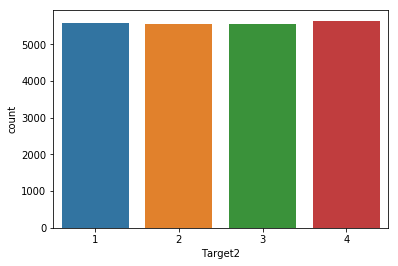

In [31]:
import seaborn as sns

sns.countplot("Target2", data=df85.toPandas())

In [13]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.feature import VectorAssembler

assembler85 = VectorAssembler(
  inputCols= df85.columns, outputCol="features")

In [14]:
output85 = assembler85.transform(df85)
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="Target2", outputCol="targetIndex")
output_fixed85 = indexer.fit(output85).transform(output85)
final_data85 = output_fixed85.select("features",'targetIndex')

In [15]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
my_binary_eval = BinaryClassificationEvaluator(labelCol = 'targetIndex')

In [16]:
train_data85,test_data85 = final_data85.randomSplit([0.8,0.2])

In [19]:
import time

start = time.time()

dtc_tree_85 = DecisionTreeClassifier(labelCol='targetIndex',featuresCol='features', maxDepth=4, minInstancesPerNode=2000)
dtc_tree_model_85 = dtc_tree_85.fit(train_data85)


tree_feature_json(dtc_tree_model_85.toDebugString, X85.columns)

dtc_tree_predictions_85 = dtc_tree_model_85.transform(test_data85)


end = time.time()
duration = end-start

print("Training duration: ", duration, " seconds")
print("Accuracy: ", my_binary_eval.evaluate(dtc_tree_predictions_85))

Conversion Success !
Training duration:  5.7157142162323  seconds
Accuracy:  0.6607036374478235


In [20]:
start = time.time()

dtc_forest_85 = RandomForestClassifier(labelCol='targetIndex',featuresCol='features')
dtc_forest_model_85 = dtc_forest_85.fit(train_data85)



dtc_forest_predictions_85 = dtc_forest_model_85.transform(test_data85)


end = time.time()
duration = end-start

print("Training duration: ", duration, " seconds")
print("Accuracy: ", my_binary_eval.evaluate(dtc_forest_predictions_85))

Training duration:  7.262090444564819  seconds
Accuracy:  0.9541034830452532
